# 프로젝트 : 새로운 데이터셋으로 나만의 이미지 분류기 만들어보기

In [41]:
# 기본적으로 필요한 모듈

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 데이터 받아오기

In [2]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)


In [3]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


## 데이터셋 형태 변경

### 기존 데이터 확인

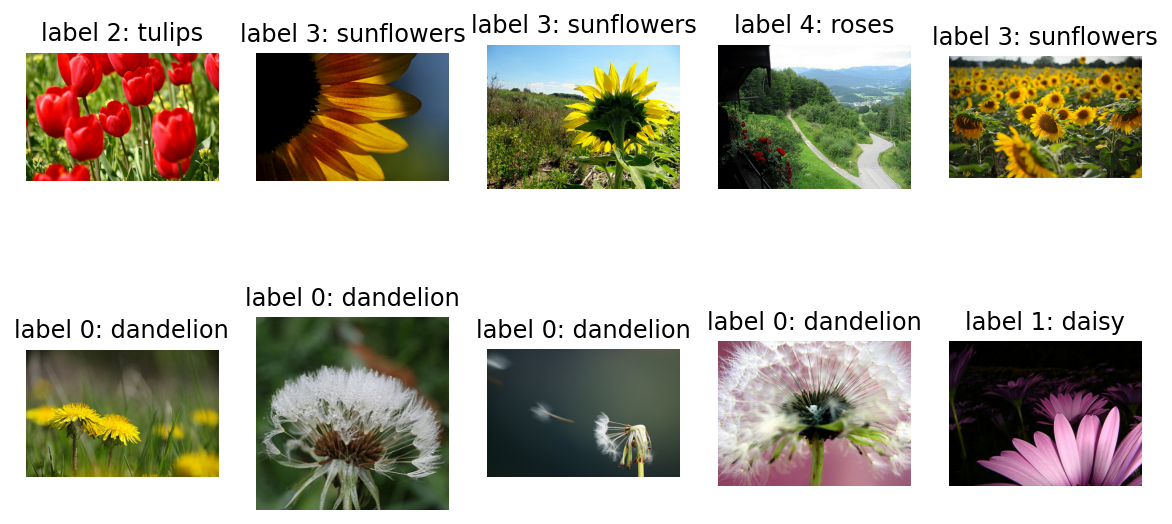

In [4]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

### 데이터 모양 변경

In [5]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)  
    # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [6]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

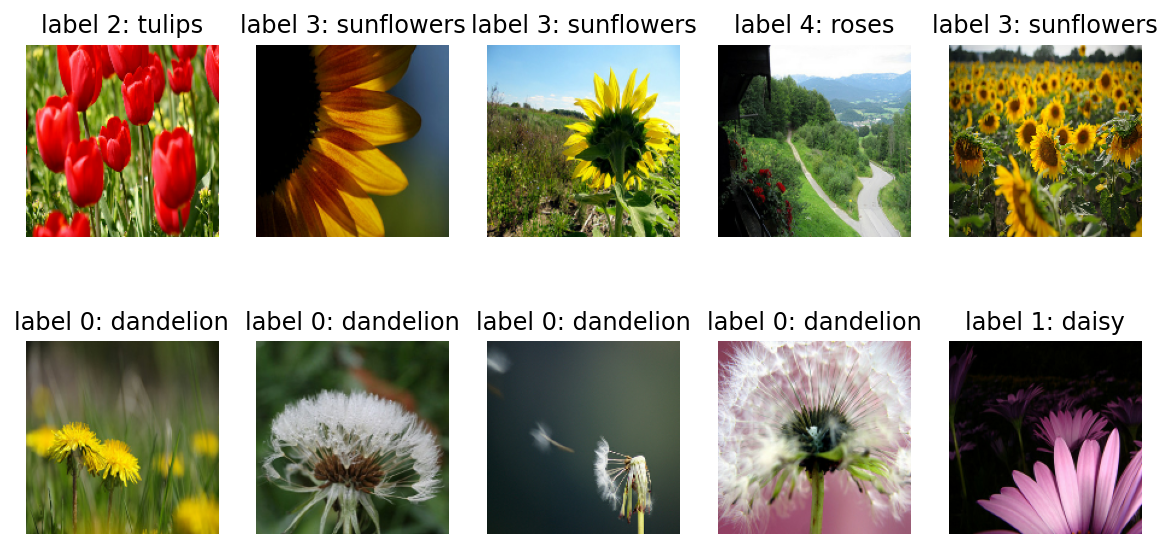

In [7]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

### 배치 만들기


In [8]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [9]:
# print(train_batches)
for image_batch, label_batch in train_batches.take(1):
    pass
print(image_batch.shape)
print(label_batch.shape)

(32, 160, 160, 3)
(32,)


## 모델 설계하기

### 우선, 예시에서 사용했던 VGG16을 base model 로 사용해보자
꽃 사진이 약 3600장정도밖에 되지않음! (데이터 수가 모델 학습시킬 때 데이터에 비해 적다.)
단, 고양이vs강아지 에서 했던 것처럼, 그림 고유의 특성을 뽑아내는 high level 레이어 변경 필요

In [10]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
print(IMG_SHAPE)


(160, 160, 3)


In [11]:
# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [12]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [13]:
print(image_batch.shape)

(32, 160, 160, 3)


여기서! 작업이 중복으로 실행되어 OOM(Out of Memory) 에러를 만났었다.
nvidia-smi 커맨드로 gpu를 차지하고 있는 큰 프로세스를 모두 종료 후, 다시 실행해보니 되었다.

In [14]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 512])

### 1차원으로 축소

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [16]:
dense_layer = tf.keras.layers.Dense(512, activation='relu')
# tf_flowers 데이터셋은 클래스 갯수가 5개이기 때문에, dense layer 의 인자로 5개를 넣어줘야한다.
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

(32, 5)


In [17]:
base_model.trainable = False

In [18]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


## 모델 학습시키기
모델을 학습시켜봅니다. 단, 여기에서는 여러 가지 옵션을 바꿔볼 수 있습니다.
예를 들어, 모델 학습을 10 epoch보다 더 많이 시켜보거나, learning_rate 값을 바꿔볼 수 있습니다.
또는, optimizer의 종류도 바꿔볼 수 있습니다. 바꿔보고 싶다면, 여기를 참고하세요.
어쩌면 VGG16이 아닌 다른 모델을 base model로 활용할 수도 있을 것입니다. 그리고 파인튜닝을 fc layer의 구성에 변화를 줄 수 있을지도 모릅니다.
이전 스텝에서는 시도하지 않았던 Regularization 기법이 적용된다면 어떨까요? Dropout이나 Batch Normalization을 적용하는 것은 그리 어려운 일이 아닙니다.

### 모델 컴파일

In [20]:
# base_learning_rate = 0.0001
# 낮춰서 진행을 해보겠다.
# base_learning_rate = 0.00005
# 올려서 진행을 해보겠다.
# base_learning_rate = 0.0002
# 다시 원래 값으로
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

### 초기 테스트

In [21]:
# print(validation_batches)
validation_steps=12
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

12/12 [==============================] - 18s 1s/step - loss: 1.6605 - accuracy: 0.2098
initial loss: 1.66
initial accuracy: 0.21


5 종류의 꽃 중, 임의로 찍어서 맞출 확률이 20%인데, 학습 전에는 그것과 비슷한 수준

### 훈련

In [22]:
# EPOCHS = 5   # 이번에는 이전보다 훨씬 빠르게 수렴되므로 5Epoch이면 충분합니다.
# 10 상승시켜본다.
# EPOCHS = 15
# 15까지 올렸을 때, 12에서 가장 높은 정확도를 보여주었기 때문에, 12로 다시 해본다.
# EPOCHS = 12
# 12까지 올렸을 때, 10에서 더 높은 정확도를 보여주었기 때문에, 10으로 다시 해본다.
# EPOCHS = 10
# 12로 올리고 learning rate 를 반으로 낮춰서 다시 해본다.
EPOCHS = 12


history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/12
92/92 [==============================] - 31s 338ms/step - loss: 1.3371 - accuracy: 0.5456 - val_loss: 1.1186 - val_accuracy: 0.6512
Epoch 2/12
92/92 [==============================] - 9s 94ms/step - loss: 1.0153 - accuracy: 0.6982 - val_loss: 0.8981 - val_accuracy: 0.7275
Epoch 3/12
92/92 [==============================] - 9s 93ms/step - loss: 0.8459 - accuracy: 0.7466 - val_loss: 0.7834 - val_accuracy: 0.7275
Epoch 4/12
92/92 [==============================] - 9s 94ms/step - loss: 0.7478 - accuracy: 0.7626 - val_loss: 0.6985 - val_accuracy: 0.7548
Epoch 5/12
92/92 [==============================] - 9s 95ms/step - loss: 0.6822 - accuracy: 0.7837 - val_loss: 0.6487 - val_accuracy: 0.7520
Epoch 6/12
92/92 [==============================] - 9s 93ms/step - loss: 0.6355 - accuracy: 0.7956 - val_loss: 0.6163 - val_accuracy: 0.7766
Epoch 7/12
92/92 [==============================] - 9s 92ms/step - loss: 0.5991 - accuracy: 0.8110 - val_loss: 0.6077 - val_accuracy: 0.7929
Epoch 8/12


## 성능 평가

### 학습 과정 살펴보기

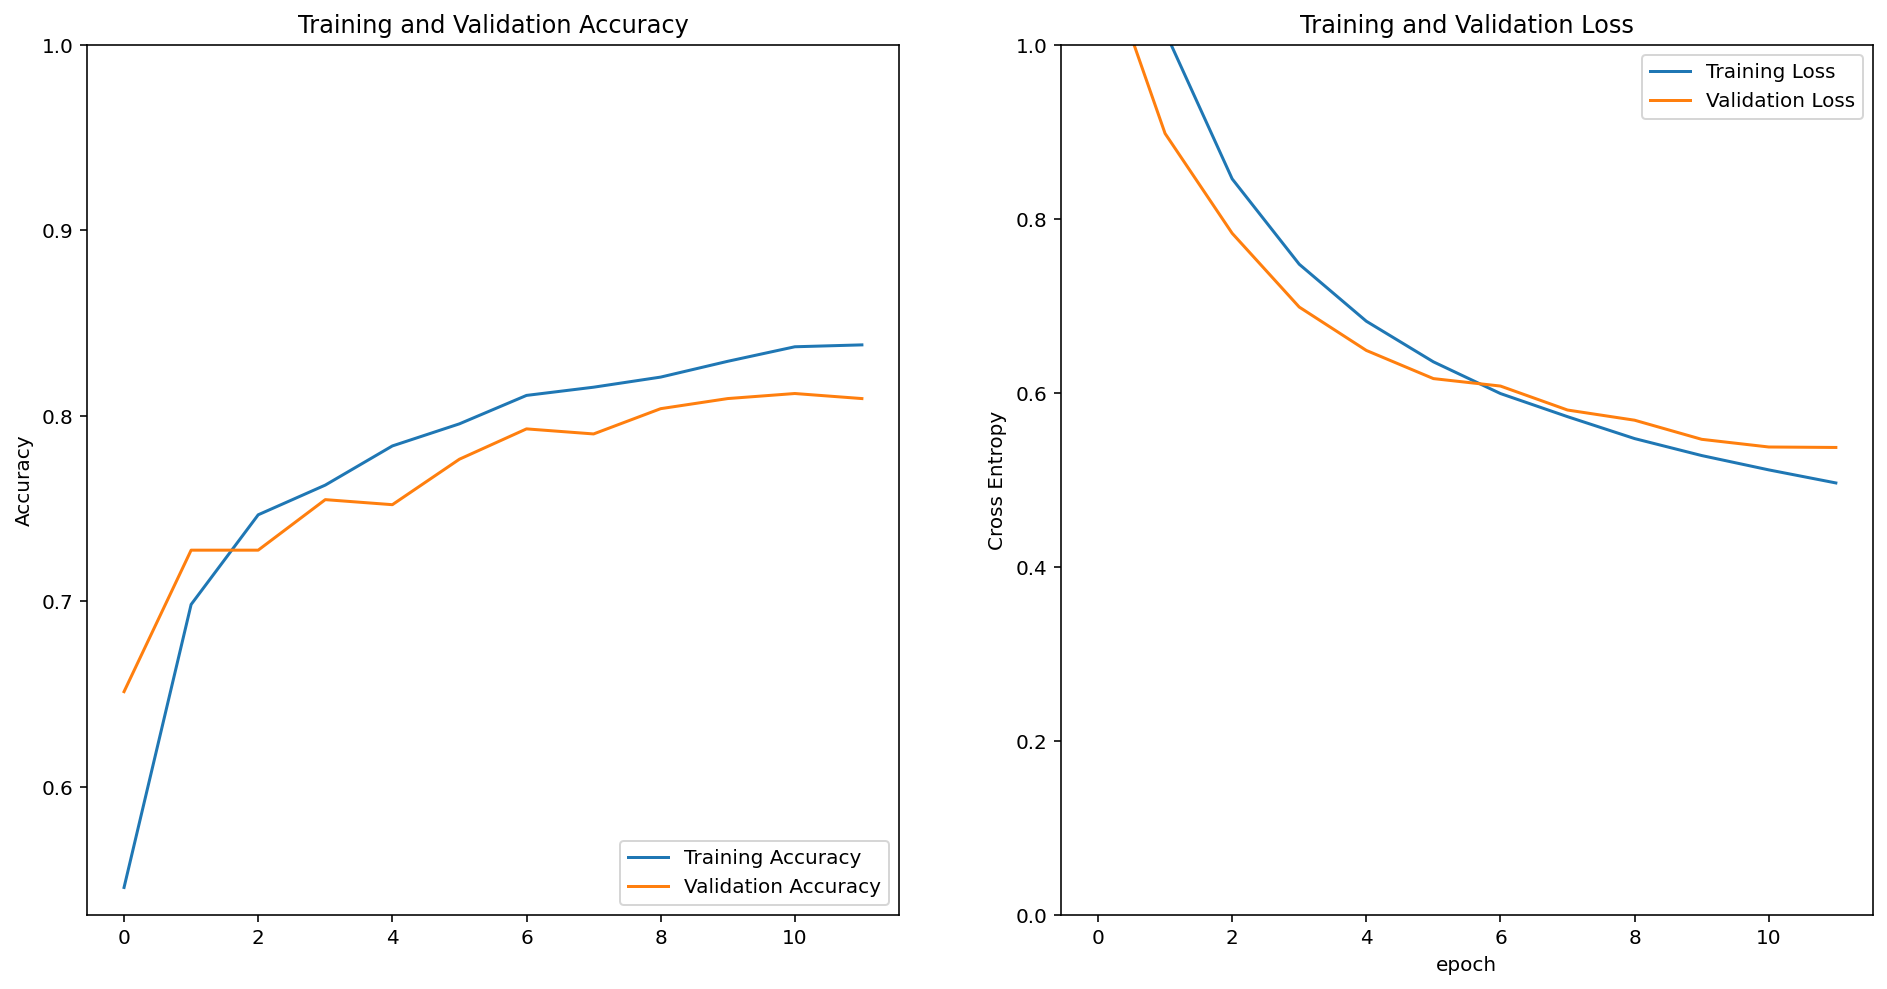

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 예측

In [24]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[2.13148016e-02, 8.65907595e-02, 7.00730145e-01, 3.91637757e-02,
        1.52200565e-01],
       [9.98856544e-01, 1.03807601e-03, 7.47806052e-06, 4.78371549e-05,
        5.00201095e-05],
       [7.64035881e-01, 1.37587473e-01, 1.62857790e-02, 6.35861456e-02,
        1.85047667e-02],
       [2.94090854e-03, 1.51521722e-02, 5.51763415e-01, 7.84780551e-03,
        4.22295749e-01],
       [6.47826493e-01, 3.06200951e-01, 1.26118157e-02, 1.15719680e-02,
        2.17887983e-02],
       [9.17132139e-01, 5.62970787e-02, 5.18538291e-03, 1.94867738e-02,
        1.89863460e-03],
       [1.47208218e-02, 2.03257892e-02, 7.46279299e-01, 1.44612506e-01,
        7.40615427e-02],
       [3.84792149e-01, 5.24826050e-01, 1.15477305e-03, 8.60590488e-02,
        3.16805439e-03],
       [1.01024257e-02, 2.69385567e-03, 3.12656984e-02, 8.69751513e-01,
        8.61865655e-02],
       [9.99275744e-01, 6.59073936e-04, 1.54863687e-06, 6.02546861e-05,
        3.32951481e-06],
       [9.65150535e-01, 3.0204

산출된 예측 값을 토대로 예측한 카테고리를 표시해본다.


In [25]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 3, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       1, 0, 1, 3, 2, 4, 4, 3, 0, 4])

산출된 예측값과 실제 값을 비교해본다.

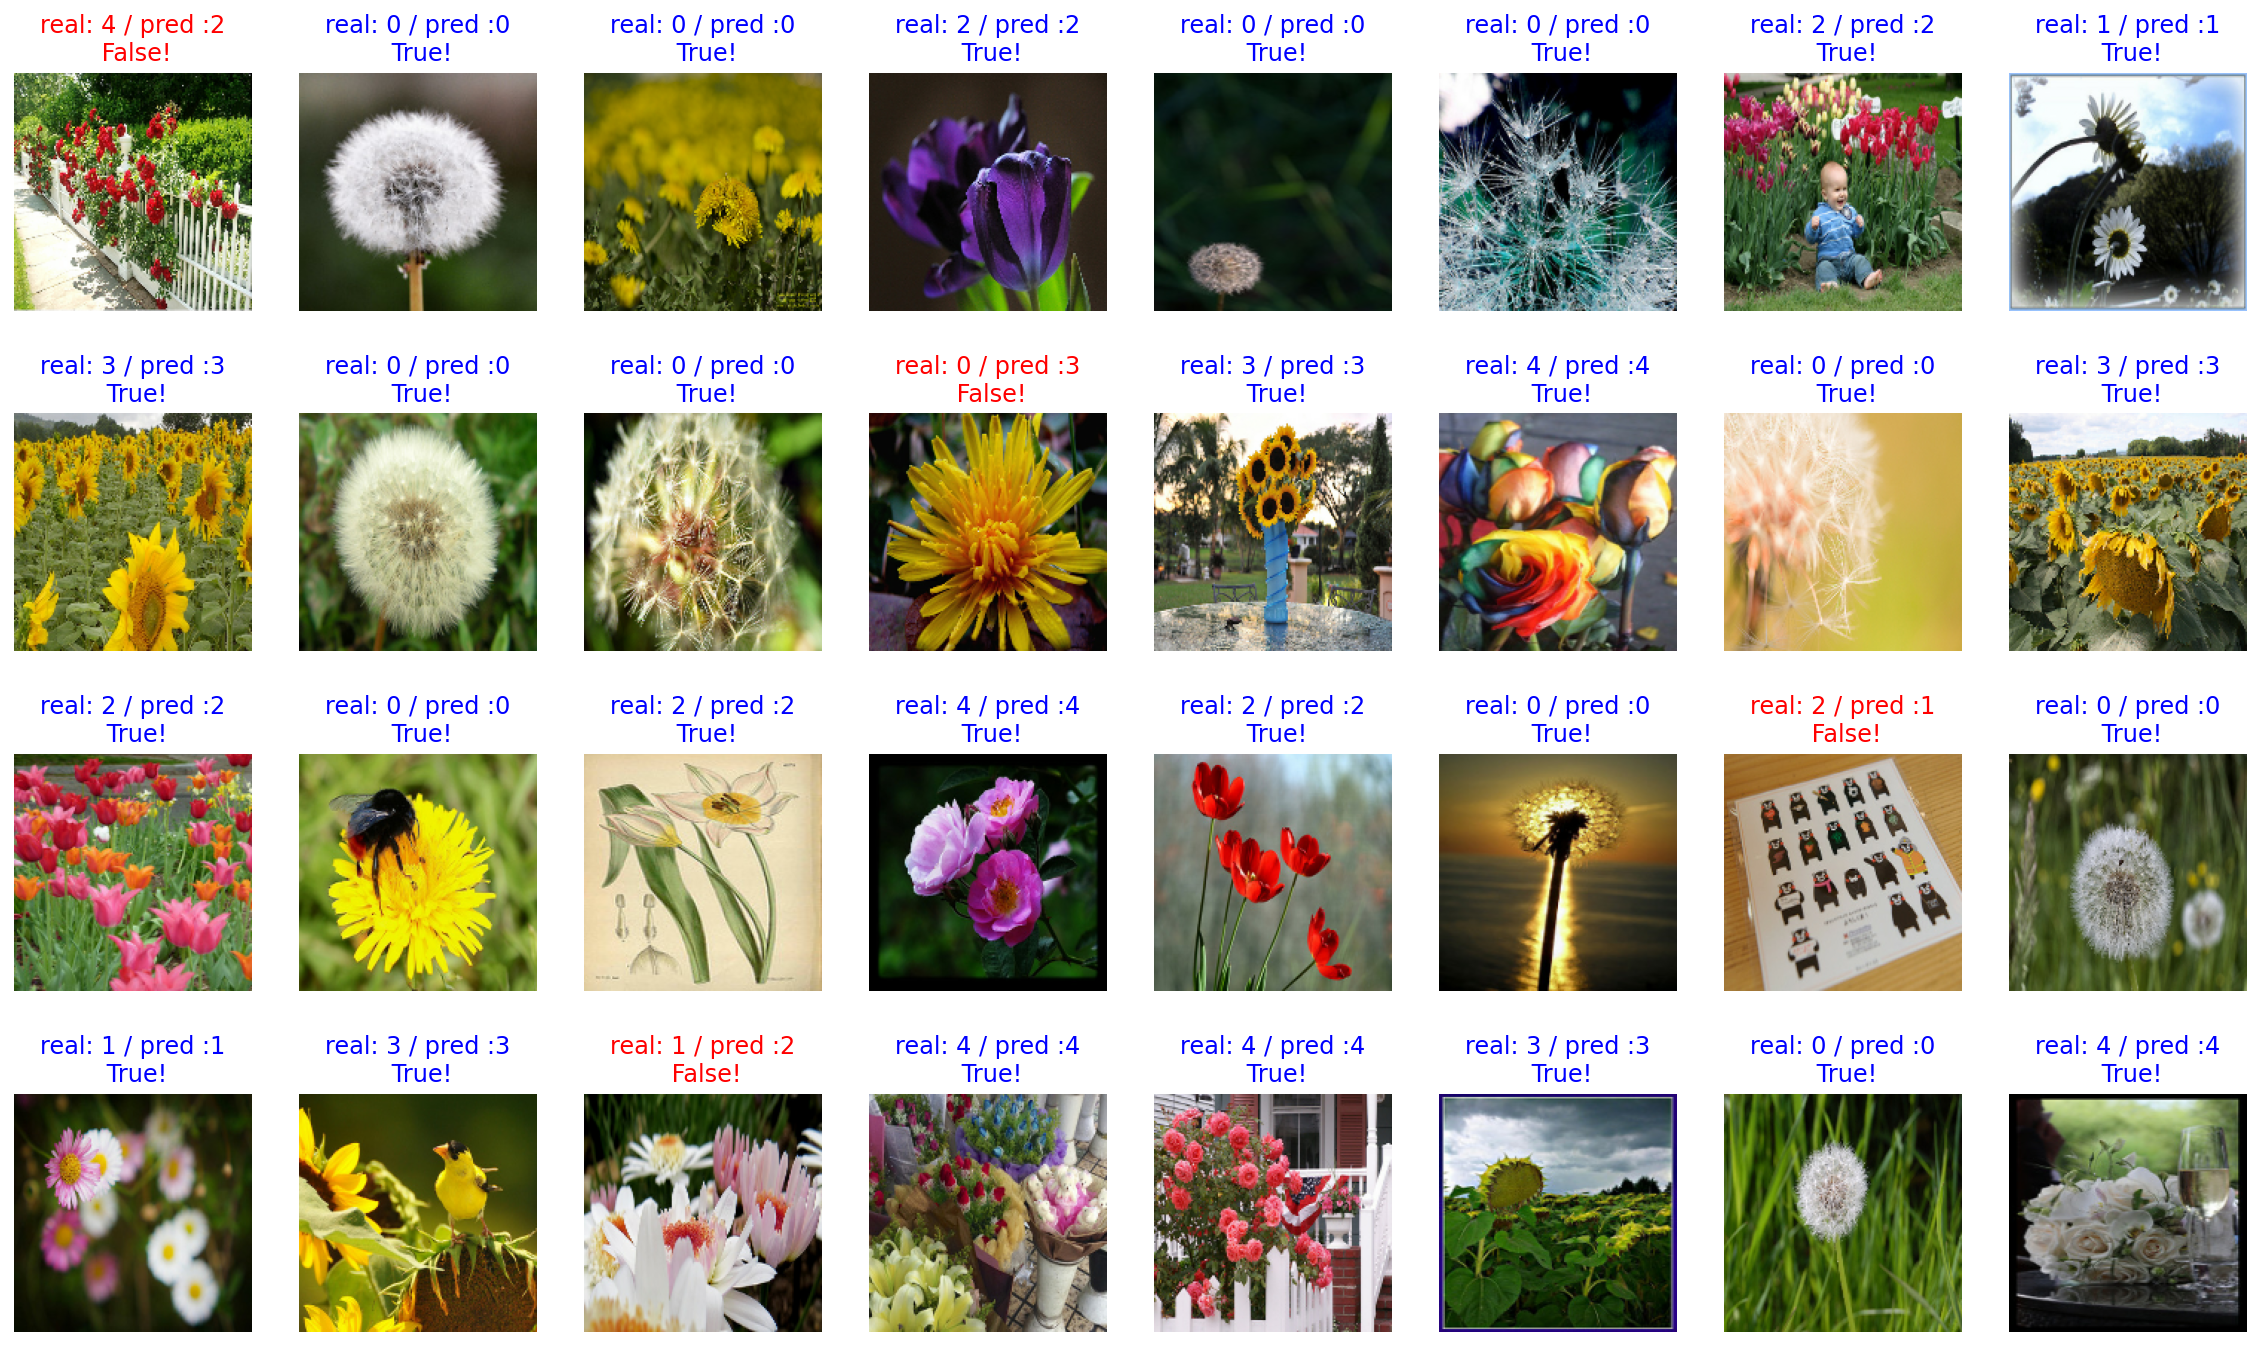

In [26]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

### 예측 정확도 측정

In [28]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100)

87.5


1. EPOCH 12 , learning rate 0.0001 일 때의 정확도 : 90.625
2. EPOCH 10 , learning rate 0.0001 일 때의 정확도 : 90.625
3. EPOCH 12 , learning rate 0.00005 일 때의 정확도 : 84.375
4. EPOCH 12 , learning rate 0.0002 일 때의 정확도 : 87.5

다시,
EPOCH 12 , learning rate 0.0001 인 경우의 정확도 : 87.5


## 모델 활용하기
모델이 구분할 수 있는 종류의 꽃 사진을 인터넷에서 구한 후, 예측시켜본다.

In [36]:
for i in range(5):
    print(get_label_name(i))

dandelion
daisy
tulips
sunflowers
roses
tf.Tensor(4, shape=(), dtype=int64)


In [47]:
img_dir_path = os.getenv("HOME") + "/aiffel/flowers"
os.path.exists(img_dir_path)

True

In [60]:
IMG_SIZE = 160
flowers_list = ['daisy','dandelion','rose','sunflower','tulip']
flower_files_path_list = []
for f in flowers_list:
    for i in range(1,3):
        name = f+'_'+str(i)+'.jpeg'    
        flower_files_path_list.append(os.path.join(img_dir_path, name))

flower_images_list = []
for fpath in flower_files_path_list:
    flower_images_list.append(
          load_img(fpath,target_size=(IMG_SIZE, IMG_SIZE))
     )

flower_img_arr_list = []
for img in flower_images_list:
    flower_img_arr_list.append( img_to_array(img).reshape(1, IMG_SIZE, IMG_SIZE, 3))

# flower_images_list
# flower_img_arr_list

    

In [61]:
for img_arr in flower_img_arr_list:
    print(model.predict(img_arr))

[[4.3526282e-28 9.9418372e-01 5.8162743e-03 1.2096009e-10 3.3908630e-14]]
[[0. 1. 0. 0. 0.]]
[[1. 0. 0. 0. 0.]]
[[9.3757659e-35 1.6549201e-06 3.6480596e-30 9.9999833e-01 2.2695139e-25]]
[[0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 1.]]
[[0.0000000e+00 1.3379065e-32 0.0000000e+00 1.0000000e+00 0.0000000e+00]]
[[0.0000000e+00 1.8310399e-17 0.0000000e+00 1.0000000e+00 0.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 3.9276108e-36]]
[[0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00 7.231038e-29]]


In [69]:
def show_and_predict_image(filepath, img_size=160):    
    # dandelion,daisy,tulips,sunflowers,roses
    image = load_img(filepath,target_size=(img_size,img_size))
    img_arr = img_to_array(image).reshape(1, img_size, img_size,3)    
    prediction = model.predict(img_arr)[0]
    dandelion_percentage = round(prediction[0] * 100)
    daisy_percentage = round(prediction[1] * 100)
    tulips_percentage = round(prediction[2] * 100)
    sunflowers_percentage = round(prediction[3] * 100)
    roses_percentage = round(prediction[4] * 100)
    print(f'Actual Image :{filepath}')
    print(f'''This image seems
    {dandelion_percentage}% dandelion
    {daisy_percentage}% daisy
    {tulips_percentage}% tulips
    {sunflowers_percentage}% sunflowers,
    {roses_percentage}% roses.
    ''')
    
for filepath in flower_files_path_list:
    show_and_predict_image(filepath,IMG_SIZE)

Actual Image :/home/aiffel0042/aiffel/flowers/daisy_1.jpeg
This image seems
    0% dandelion
    99% daisy
    1% tulips
    0% sunflowers,
    0% roses.
    
Actual Image :/home/aiffel0042/aiffel/flowers/daisy_2.jpeg
This image seems
    0% dandelion
    100% daisy
    0% tulips
    0% sunflowers,
    0% roses.
    
Actual Image :/home/aiffel0042/aiffel/flowers/dandelion_1.jpeg
This image seems
    100% dandelion
    0% daisy
    0% tulips
    0% sunflowers,
    0% roses.
    
Actual Image :/home/aiffel0042/aiffel/flowers/dandelion_2.jpeg
This image seems
    0% dandelion
    0% daisy
    0% tulips
    100% sunflowers,
    0% roses.
    
Actual Image :/home/aiffel0042/aiffel/flowers/rose_1.jpeg
This image seems
    0% dandelion
    0% daisy
    0% tulips
    0% sunflowers,
    100% roses.
    
Actual Image :/home/aiffel0042/aiffel/flowers/rose_2.jpeg
This image seems
    0% dandelion
    0% daisy
    0% tulips
    0% sunflowers,
    100% roses.
    
Actual Image :/home/aiffel0042/aiff

인터넷에서 수집한 사진들 10장으로 모델을 사용해본 결과,  dandelion 1장이 sunflower 로 표시되는 것을 제외하고 모두 정확하게 예측하였다. 아래에 해당 이미지를 띄워보았다.

(-0.5, 159.5, 159.5, -0.5)

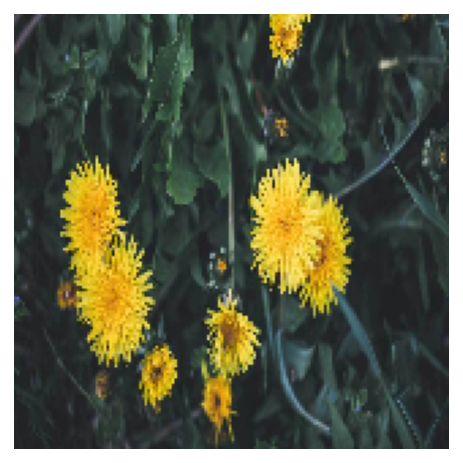

In [70]:
plt.imshow(flower_images_list[3])
plt.axis('off')

## 모델 저장해놓기

In [66]:
checkpoint_dir = os.getenv("HOME") + "/aiffel/flowers/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')
    
model.save_weights(checkpoint_file_path)     # checkpoint 파일 생성

if os.path.exists(checkpoint_file_path):
  print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!


# 결과 보고서

## OOM
 base_model 에 image_batch 를 넣어서 feature_batch 를 얻어서 base_model 의 출력값을 확인해보는 과정에서 OOM 에러가 발생하였다. 분명 LMS에 있는 그대로의 코드를 사용했는데 지속적으로 오류가 발생하고, batch size 를 1로 극단적으로 줄여봐도 에러가 발생하였다.
 그래서, 그래픽카드 메모리를 사용중인 프로세스를 확인하여, 그래픽카드를 사용중인 tensorflow 프로세스를 모두 종료한 이후 다시 작업을 진행하였다. 아마 어딘가에서 중복으로 실행되어 그런 것으로 짐작되는데, 다음에 비슷한 오류를 만난다면 비슷한 방법으로 해결할 수 있을 것 같다.
 
 ## CNN 구조에 대한 이해
  띄엄띄엄 공부를 했을 때, CNN 의 구조도를 살펴보았을 때, 도대체 어떤 이유로 그런 모양을 가지게 되는지 직관적인 이해를 하지 못한 상태로 넘어갔었다. 그런데, 이번 과정을 통해 대략의 맥락을 이해할 수 있었다. 물론, 각 layer가 정확히 어떤 방식으로 input vector 를 변경시켜 나가는 것인지는 추후 배울 것으로 생각되기 때문에, 이번에 이해한 맥락을 토대로 구체적인 내용을 이해할 수 있을 것이라 기대된다.
  
  
 ##  Transfer Learning 이용 방법론에 대한 이해
  Transfer Learning 이라는 것이 많은 컴퓨팅 파워를 통해 미리 학습된 모델을 가져와서 활용하는 것이라는 개념에 대해서는 알고 있었지만, 실제로 이용할 때 어떤 것들을 고려하여야 하는지, 어떻게 기존 모델을 수정할 수 있는 지에 대해서는 알지 못했었다. 이번 과정에서 해당 부분들에 대해 익히고 생각해볼 수 있는 기회였다.